# Solution: Coding a vector-borne disease (VBD) model

## Differential equations for the simple VBD model

\begin{align}
\frac{dS_V}{dt} &= \mu_V N_V - \frac{a b_V}{N_H} S_V I_H - \mu_V S_V \\
\frac{dI_V}{dt} &= \frac{a b_V}{N_H} S_V I_H - \mu_V I_V \\
\frac{dS_H}{dt} &= - \frac{a b_H}{N_H} S_H I_V \\
\frac{dI_H}{dt} &= \frac{a b_H}{N_H} S_H I_V - r I_H \\
\frac{dR_H}{dt} &= r I_H
\end{align}

### What assumptions are you making using this model structure? Consider the host and vector population, transmission dynamics and biting behaviour, and the natural history of infection.

Some assumptions underlying this model structure are:
- host and vector population: there are no births, background deaths or disease-induced mortality in the host population. Vectors enter the population and die at the same rate, therefore the mosquito population size remains constant over time. Vector survival is independent of infection status, and recruitment of new vectors into the transmission cycle ($\mu_V N_V$) depends on the vector population size. There is no heterogeneity in the host or vector population, which means vectors and bites are homogeneously distributed among people. 
- transmission dynamics and biting behaviour: transmission occurs only from vector to host and from host to vector (no host-host or vector-vector transmission). The mosquito takes all blood meals from humans (H=1 so this is not represented in the equations).
- natural history of infection: hosts are infectious as soon as they are infected, and can recover. Recovery induces permanent immunity in hosts, i.e. there is no re-infection. Vectors are infectious as soon as they get infected and remain infectious until they die.

## Parameter values

- Biting rate $a$ = 1 days$^{-1}$
- Probability of infection from an infected host to a susceptible vector, $b_V$ = 0.4
- Probability of infection from an infected vector to a susceptible host, $b_H$ = 0.4
- Mortality rate of the vector $\mu_V$ = 0.25 days$^{-1}$
- Recovery rate of the host, $r$ = 0.167 days$^{-1}$

### In 1 sentence each, describe what these 5 parameters mean in terms of frequency of biting, transmission probability, vector life expectancy and duration of dengue infection. 

With these parameter values, we assume that:

- Biting rate $a$ = 1 days$^{-1}$: Each mosquito bites a human once a day (all bloodmeals are taken from humans). 
- Probability of infection from an infected host to a susceptible vector, $b_V$ = 0.4: When a mosquito bites an infected human, the probability that the mosquito becomes instantaneously infected is 40%.
- Probability of infection from an infected vector to a susceptible host, $b_H$ = 0.4: When a human gets bitten by an infectious mosquito, the human becomes infected with a probability of 40%.
- Mortality rate of the vector $\mu_V$ = 0.25 days$^{-1}$: the *Aedes aegypti* mosquito has an average life expectancy of 1/0.25 = 4 days.
- Recovery rate of the host, $r$ = 0.167 days$^{-1}$: dengue infection in humans lasts 1/0.167 = 6 days on average.

## Code for a single-serotype dengue model

Loading required package: deSolve
Loading required package: reshape2
Loading required package: ggplot2


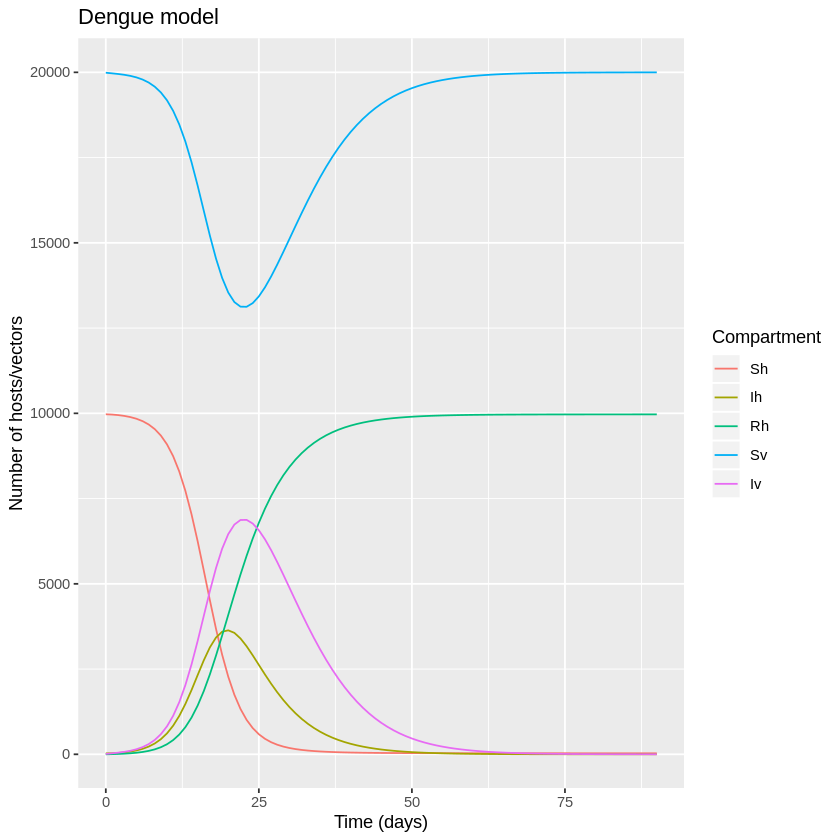

In [1]:
# PACKAGES
require(deSolve)
require(reshape2)
require(ggplot2)

# INPUT
Nh <- 10000   # total number of hosts
Nv <- 20000   # total number of vectors

initial_state_values <- c(Sh = Nh-0.0028*Nh, 
                          Ih = 0.0028*Nh, 
                          Rh = 0, 
                          Sv = Nv-0.00057*Nv,
                          Iv = 0.00057*Nv)

parameters <- c(a = 1,       # mosquito biting rate per day
                b_v = 0.4,   # probability of infection from an infected host to a susceptible vector
                b_h = 0.4,   # probability of infection from an infected vector to a susceptible host
                u_v = 0.25,  # mortality/recruitment rate of the vector
                r = 0.167)   # recovery rate from dengue in humans

times <- seq(from = 0, to = 90, by = 1)    # simulate for 3 months (90 days)

# SIR MODEL FUNCTION
vbd_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    Nh <- Sh + Ih + Rh   # total human population
    Nv <- Sv + Iv        # total vector population
      
    # The differential equations
    # Host population dynamics:
    dSh <- -a*b_h*Sh*Iv/Nh
    dIh <- a*b_h*Sh*Iv/Nh - r * Ih
    dRh <- r * Ih
    # Vector population dynamics:
    dSv <- u_v * Nv - a*b_v*Sv*Ih/Nh - u_v * Sv
    dIv <- a*b_v*Sv*Ih/Nh - u_v * Iv            
    
    # Output
    return(list(c(dSh, dIh, dRh, dSv, dIv))) 
  })
}

# Solve the equations
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = vbd_model,
                            parms = parameters))

output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Plot the number of mosquitoes and humans in each compartment over 3 months
ggplot(data = output_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of hosts/vectors") +                                     
  labs(colour = "Compartment",                                           
       title = "Dengue model")     

## Sensitivity of infection prevalence to the biting rate

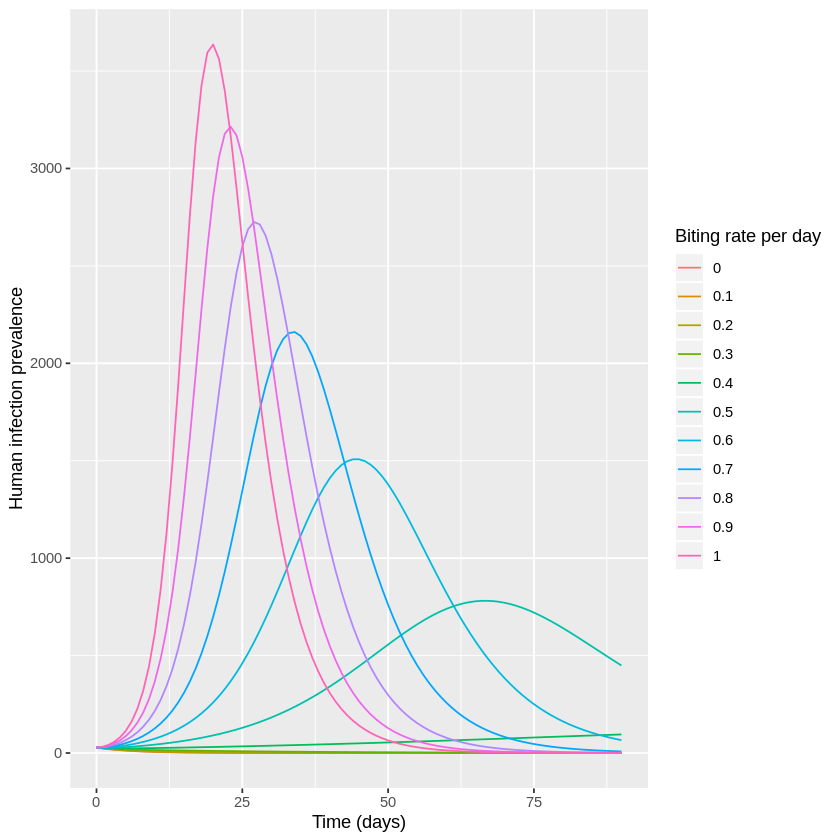

In [2]:
a_values <- seq(0,1,by=0.1)                         # a vector of values for the biting rate, ranging from 0 to 1 per day
out_list <- vector(length(a_values), mode = "list") # create an object (list) to store the output for each value of a

for (i in seq_along(a_values)) {      # start for loop: for each value in the a_values vector...

# ... simulate the model and store the output in the out_list object:
out_list[[i]] <- as.data.frame(ode(y = initial_state_values, 
                                   times = times, 
                                   func = vbd_model,
                                   parms = c(parameters[c("b_v", "b_h", "u_v", "r")], 
                                             a = a_values[i])))
}                                      # close the loop
                                   
names(out_list) <- a_values            # rename list elements according to the corresponding biting rate value
                                   
# Extract the infected host column from the list and creating a dataframe by time
out_inf <- cbind(time = out_list[[1]]$time, 
                 sapply(out_list, 
                        "[[", 
                        "Ih"))    # fill in the name of your column for infected hosts                          

# Turn into long format                                
out_inf_long <- melt(as.data.frame(out_inf), id = "time") 

# Plot the infection prevalence for each biting rate value                                   
ggplot(data = out_inf_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +
  xlab("Time (days)") +                                                   
  ylab("Human infection prevalence") +                                     
  labs(colour = "Biting rate per day")   

### How do assumptions of the mosquito biting activity affect the human infection prevalence?

For an average number of 0-0.3 bites per mosquito per day, no dengue epidemic occurs. An outbreak only occurs for values of 0.4 and above, with increasing values of $a$ producing higher peak epidemic sizes and shorter durations.

### What might affect the average number of bites a mosquito takes per unit time? Is it realistic to assume that the biting rate stays constant over time in the simulation?

The biting rate, just like other vector-related parameters, can be influenced by a wide range of environmental factors such the temperature and rainfall. Over a short time period, assuming a constant biting rate may be fine, but accounting for seasonality is important over longer timescales (as is turnover in the human host population). The biting rate can also be affected by the host's behaviour, for example if humans take measures to avoid mosquito bites (e.g. wearing long-sleeve clothing). 

### How could you extend this model for a more realistic representation of dengue transmission dynamics?

This would depend on the research question, but in general a more realistic model structure could be achieved by representing mosquito population dynamics and the natural history of dengue infection. For example, dengue models usually account for the intrinsic incubation period (latent period in humans) and extrinsic incubation period (latent period in the vector), i.e. the time between exposure to infection and the bite becoming infectious. Only adult mosquitoes are involved in transmission, but different developmental stages from larvae to adult could be represented, particularly if we are interested in studying changes in the mosquito population e.g. in relation to environmental factors. Severe cases of dengue infection occur as a result of secondary infection with a different serotype, so the co-circulation of different serotypes would be important to account for when studying disease burden of dengue in humans. 